In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import savgol_filter

In [2]:
# Baca file CSV
file_path = '/run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy.csv'
df = pd.read_csv(file_path)
print(f"Memproses data untuk file {file_path}...")

Memproses data untuk file /run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy.csv...


In [3]:
# Set date sebagai indeks
df.set_index('Date', inplace=True)

df.head(5)

,Year,Month,Day,SWRad,StDev,Max,Q,S
Date,,,,,,,,
2005-01-01,2005,Januari,1,155.61,189.97,681.56,2,5
2005-01-02,2005,Januari,2,57.16,83.72,289.75,2,5
2005-01-03,2005,Januari,3,130.86,171.20,694.65,2,5
2005-01-04,2005,Januari,4,269.79,352.19,1284.63,2,5
2005-01-05,2005,Januari,5,79.43,134.50,645.00,2,5


In [4]:
# 1. Penanganan Missing Values
print("\n--- LANGKAH 1: PENANGANAN MISSING VALUES ---")
before_cleaning = df.isna().sum()
print(f"Missing values sebelum cleaning:\n{before_cleaning}")


--- LANGKAH 1: PENANGANAN MISSING VALUES ---
Missing values sebelum cleaning:
Year      0
Month     0
Day       0
SWRad    14
StDev    14
Max      23
Q         0
S         0
dtype: int64


In [5]:
# Handle missing values berdasarkan Quality Code
def handle_missing_radiation(row):
    # Jika data radiasi hilang, tandai Q=0 (Datum Missing)
    if pd.isna(row['SWRad']):
        return 0
    return row['Q']

In [6]:
# Update Quality Code untuk data yang hilang
df['Q'] = df.apply(handle_missing_radiation, axis=1)

In [7]:
# Impute missing Max values jika SWRad dan StDev tersedia
# Menggunakan pendekatan konservatif: Max = SWRad + 2*StDev
mask = pd.isna(df['Max']) & ~pd.isna(df['SWRad']) & ~pd.isna(df['StDev'])
df.loc[mask, 'Max'] = df.loc[mask, 'SWRad'] + 2 * df.loc[mask, 'StDev']
print(f"Imputed {mask.sum()} missing Max values with conservative estimation")

Imputed 9 missing Max values with conservative estimation


In [8]:
print(f"Missing values setelah penanganan awal:\n{df.isna().sum()}")

Missing values setelah penanganan awal:
Year      0
Month     0
Day       0
SWRad    14
StDev    14
Max      14
Q         0
S         0
dtype: int64


In [9]:
# 2. Filtering Data Berdasarkan Quality dan Source Codes
print("\n--- LANGKAH 2: FILTERING BERDASARKAN QUALITY & SOURCE CODES ---")
print(f"Distribusi Quality Code (Q):\n{df['Q'].value_counts().sort_index()}")
print(f"Distribusi Source Code (S):\n{df['S'].value_counts().sort_index()}")


--- LANGKAH 2: FILTERING BERDASARKAN QUALITY & SOURCE CODES ---
Distribusi Quality Code (Q):
Q
0      14
1    1322
2    2223
Name: count, dtype: int64
Distribusi Source Code (S):
S
0      14
1    1576
5    1969
Name: count, dtype: int64


In [10]:
# Buat copy data untuk proses cleaning
df_clean = df.copy()

In [11]:
df_clean['Q'] = df_clean['Q'].astype('Int64')
df_clean['S'] = df_clean['S'].astype(int)

In [12]:
# Filter out data dengan Q=0 (datum missing) dan Q=5 (sensor failed)
df_clean = df_clean[~df_clean['Q'].isin([0, 5])]
print(f"Menghapus {len(df) - len(df_clean)} baris dengan Q=0 atau Q=5")

Menghapus 14 baris dengan Q=0 atau Q=5


In [13]:
# Prioritaskan data berdasarkan Source Code
# Jika ada duplikat timestamp, prioritaskan S=5 (Recovered from RAM) dibanding S lainnya
def prioritize_source(group):
    if len(group) == 1:
        return group
    # Prioritaskan S=5, kemudian S=1
    if 5 in group['S'].values:
        return group[group['S'] == 5].iloc[0:1]
    elif 1 in group['S'].values:
        return group[group['S'] == 1].iloc[0:1]
    else:
        return group.iloc[0:1]

In [14]:
# Check for duplicate timestamps
if df_clean.index.duplicated().any():
    print(f"Ditemukan {df_clean.index.duplicated().sum()} Date duplikat, memprioritaskan data berdasarkan Source Code")
    df_clean = df_clean.groupby(level=0).apply(prioritize_source)
    df_clean = df_clean.droplevel(1) if df_clean.index.nlevels > 1 else df_clean

In [15]:
# 3. Deteksi dan Penanganan Outliers
print("\n--- LANGKAH 3: DETEKSI DAN PENANGANAN OUTLIERS ---")

# Deteksi outliers menggunakan metode Z-score
def detect_outliers_z_score(df, column, threshold=3):
    z_scores = stats.zscore(df[column], nan_policy='omit')
    outliers = np.abs(z_scores) > threshold
    return outliers

# Deteksi outliers berdasarkan batas fisik/logis
def detect_physical_outliers(df):
    # Batas fisik untuk SWRad (W/m²)
    max_possible = 1400  # Nilai teoritis maksimum untuk radiasi matahari di permukaan bumi
    min_possible = 0     # Radiasi tidak bisa negatif
    
    # Deteksi nilai tidak logis
    physical_outliers = (df['SWRad'] > max_possible) | (df['SWRad'] < min_possible)
    return physical_outliers

# Deteksi outliers berdasarkan ketidaksesuaian Max dan SWRad
def detect_inconsistent_max(df):
    # Max harus lebih besar atau sama dengan SWRad
    inconsistent = (df['Max'] < df['SWRad']) & ~pd.isna(df['Max']) & ~pd.isna(df['SWRad'])
    return inconsistent


--- LANGKAH 3: DETEKSI DAN PENANGANAN OUTLIERS ---


In [16]:
# Terapkan deteksi outliers
z_outliers = detect_outliers_z_score(df_clean, 'SWRad', threshold=3.5)
physical_outliers = detect_physical_outliers(df_clean)
inconsistent_max = detect_inconsistent_max(df_clean)

In [17]:
# Kombinasikan semua outliers
all_outliers = z_outliers | physical_outliers | inconsistent_max
outlier_count = all_outliers.sum()

In [18]:
print(f"Terdeteksi outliers: {outlier_count} ({outlier_count/len(df_clean)*100:.2f}% dari data)")
print(f"  - Z-score outliers: {z_outliers.sum()}")
print(f"  - Physical outliers: {physical_outliers.sum()}")
print(f"  - Inconsistent Max values: {inconsistent_max.sum()}")

Terdeteksi outliers: 0 (0.00% dari data)
  - Z-score outliers: 0
  - Physical outliers: 0
  - Inconsistent Max values: 0


In [19]:
# Ubah Quality Code untuk outliers (jika bukan Q=3 atau Q=4)
df_clean.loc[all_outliers & ~df_clean['Q'].isin([3, 4]), 'Q'] = 4
print(f"Quality code diperbarui untuk {(all_outliers & ~df_clean['Q'].isin([3, 4])).sum()} outliers")

Quality code diperbarui untuk 0 outliers


In [20]:
# 4. Smoothing Data (hanya pada data selain outliers)
print("\n--- LANGKAH 4: SMOOTHING DATA ---")

# Membuat kolom baru untuk data yang telah di-smooth
df_clean['SWRad_Smoothed'] = df_clean['SWRad'].copy()


--- LANGKAH 4: SMOOTHING DATA ---


In [21]:
# Hanya smooth data yang valid (Q=1 atau Q=2)
valid_mask = df_clean['Q'].isin([1, 2])
valid_data = df_clean[valid_mask]

In [22]:
if len(valid_data) > 10:
    # Gunakan Savitzky-Golay filter untuk smoothing (keseimbangan antara menghaluskan noise dan mempertahankan pola sebenarnya)
    window_length = min(11, len(valid_data) - (len(valid_data) % 2) - 1)  # Window harus ganjil dan < jumlah data
    if window_length >= 3:
        try:
            # Tambahkan kolom SWRad_Smoothed
            smoothed = savgol_filter(valid_data['SWRad'], window_length, 2)
            df_clean.loc[valid_mask, 'SWRad_Smoothed'] = smoothed
            print(f"Smoothing berhasil diterapkan menggunakan Savitzky-Golay filter (window={window_length})")
        except Exception as e:
            print(f"Gagal menerapkan smoothing: {e}")
    else:
        print("Jumlah data valid terlalu sedikit untuk smoothing Savitzky-Golay")
else:
    print("Jumlah data valid tidak mencukupi untuk proses smoothing")

Smoothing berhasil diterapkan menggunakan Savitzky-Golay filter (window=11)


In [23]:
# 5. Visualisasi Hasil
print("\n--- LANGKAH 5: VISUALISASI HASIL ---")

# Plot data asli dan sudah difilter
plt.figure(figsize=(15, 10))


--- LANGKAH 5: VISUALISASI HASIL ---


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

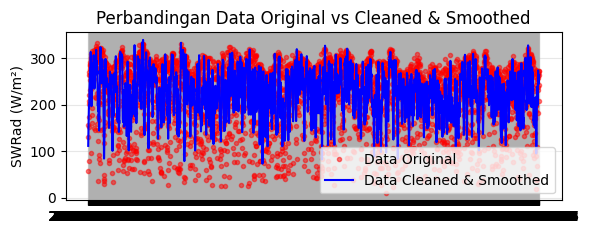

In [24]:
# Plot 1: Data asli vs Data bersih
plt.subplot(2, 1, 1)
plt.plot(df.index, df['SWRad'], 'r.', alpha=0.5, label='Data Original')
plt.plot(df_clean.index, df_clean['SWRad_Smoothed'], 'b-', label='Data Cleaned & Smoothed')
plt.legend()
plt.title('Perbandingan Data Original vs Cleaned & Smoothed')
plt.ylabel('SWRad (W/m²)')
plt.grid(True, alpha=0.3)

Text(0, 0.5, 'Jumlah Data')

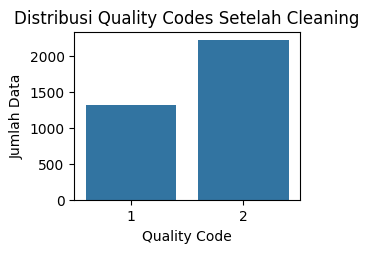

In [25]:
# Plot 2: Distribusi Quality Codes setelah cleaning
plt.subplot(2, 2, 3)
sns.countplot(x='Q', data=df_clean)
plt.title('Distribusi Quality Codes Setelah Cleaning')
plt.xlabel('Quality Code')
plt.ylabel('Jumlah Data')

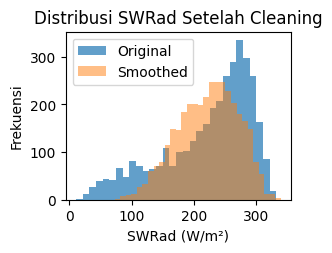

In [26]:
# Plot 3: Histogram data setelah cleaning
plt.subplot(2, 2, 4)
plt.hist(df_clean['SWRad'], bins=30, alpha=0.7, label='Original')
plt.hist(df_clean['SWRad_Smoothed'], bins=30, alpha=0.5, label='Smoothed')
plt.title('Distribusi SWRad Setelah Cleaning')
plt.xlabel('SWRad (W/m²)')
plt.ylabel('Frekuensi')
plt.legend()

In [27]:
plt.tight_layout()
plt.savefig('radiation_data_cleaning_results.png')
print("Visualisasi disimpan sebagai 'radiation_data_cleaning_results.png'")

Visualisasi disimpan sebagai 'radiation_data_cleaning_results.png'


<Figure size 640x480 with 0 Axes>

In [28]:
# 6. Statistik Hasil
print("\n--- LANGKAH 6: STATISTIK HASIL CLEANING ---")
print(f"Jumlah data original: {len(df)}")
print(f"Jumlah data setelah cleaning: {len(df_clean)}")
print(f"Persentase data yang dipertahankan: {len(df_clean)/len(df)*100:.2f}%")


--- LANGKAH 6: STATISTIK HASIL CLEANING ---
Jumlah data original: 3559
Jumlah data setelah cleaning: 3545
Persentase data yang dipertahankan: 99.61%


In [29]:
print("\nStatistik Data Original:")
print(df['SWRad'].describe())

print("\nStatistik Data Cleaned:")
print(df_clean['SWRad_Smoothed'].describe())


Statistik Data Original:
count    3545.000000
mean      222.076559
std        70.980748
min        10.480000
25%       179.910000
50%       243.750000
75%       276.380000
max       332.160000
Name: SWRad, dtype: float64

Statistik Data Cleaned:
count    3545.000000
mean      222.080485
std        47.736718
min        72.850699
25%       187.997902
50%       226.187016
75%       258.026364
max       339.287762
Name: SWRad_Smoothed, dtype: float64


In [30]:
# 7. Simpan hasil
output_path = file_path.replace('.csv', '_cleaned.csv')
df_clean.to_csv(output_path)
print(f"\nData bersih berhasil disimpan ke {output_path}")


Data bersih berhasil disimpan ke /run/media/cryptedlm/localdisk/Kuliah/Tugas Akhir/Dataset/Buoys/0N90E/ASCII/convert/rad0n90e_dy_cleaned.csv


In [31]:
# Tampilkan informasi akhir
print("\n--- RINGKASAN PROSES CLEANING ---")
print(f"1. {len(df) - len(df_clean)} baris data difilter keluar")
print(f"2. {mask.sum()} missing Max values di-impute")
print(f"3. {outlier_count} outliers ditandai dengan Quality Code = 4")
print(f"4. Smoothing diterapkan menggunakan Savitzky-Golay filter")
print(f"5. Hasil disimpan sebagai file CSV dan visualisasi")


--- RINGKASAN PROSES CLEANING ---
1. 14 baris data difilter keluar
2. 9 missing Max values di-impute
3. 0 outliers ditandai dengan Quality Code = 4
4. Smoothing diterapkan menggunakan Savitzky-Golay filter
5. Hasil disimpan sebagai file CSV dan visualisasi
